# OAC-misalign演示

本脚本利用合成数据，展示了时域-相位不对齐的空中计算现象，以及解决方案

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from PIL import Image
# %matplotlib auto
L_symbols = 256    # 发送符号数
M_users = 14    # 用户数
SNR_db_global = 0
# # 生成新数据
# d_data = np.random.randn(M_users,L_symbols)

# image = Image.fromarray((d_data * 20. + 128).astype('uint8'))  # 将小数转换为0-255的整数

# # 保存为png文件
# image.save('d_data.png')

# 读取数据
loaded_image = Image.open('d_data_1.png').convert('L')
loaded_array = np.array(loaded_image)
# d_data = (loaded_array.astype('float32') - 128) / 20.  # 将0-255的整数转换回小数
d_data = loaded_array.astype('float32') / 255.
# d_data = np.clip(d_data,-1.0,1.0)
baseband = np.ones(L_symbols)

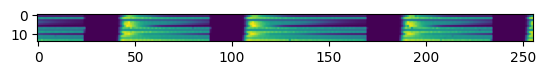

In [2]:
def awgn(x, snr):
    '''Add AWGN
    x: numpy array
    snr: int, dB
    '''
    len_x = x.flatten().shape[0]
    Ps = np.sum(np.power(x, 2)) / len_x
    Pn = Ps / (np.power(10, snr / 10))
    noise = np.random.randn(x.shape[0],x.shape[1]) * np.sqrt(Pn)/2 + 1j * (np.random.randn(x.shape[0],x.shape[1]) * np.sqrt(Pn)/2)
    return x + noise

def get_pn(x, snr):
    len_x = x.flatten().shape[0]
    Ps = np.sum(np.power(x, 2)) / len_x
    Pn = Ps / (np.power(10, snr / 10))    
    return Pn

plt.imshow(d_data)
plt.show()


In [3]:
hh = np.exp(1j*np.random.uniform(0,1,(M_users,1)) * 4* np.pi /4)
data = np.random.randint(0,2,(M_users,1))
data_2 = data*hh
print(np.mean(np.abs(np.sum(data,axis=0)-np.sum(data_2,axis=0))**2))

67.64968184492386


2. 混叠数据，并加噪、加相位旋转（待实现）

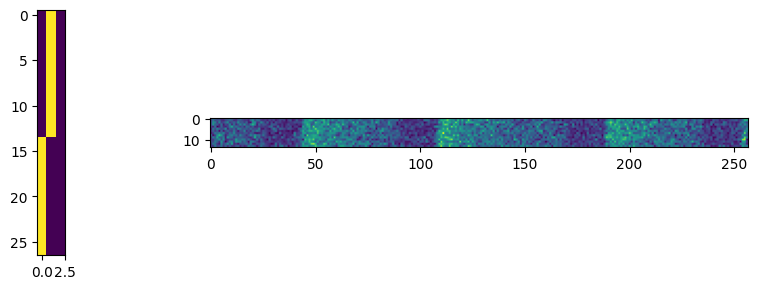

[0.627451   0.00784314 0.5882353  0.1764706  0.28627452 0.16862746
 0.00784314 0.5137255  0.4117647  0.5882353  0.16862746 0.5254902
 0.4745098  0.7058824 ]
[-4.19829517-0.43848664j  2.55579862+0.34021946j -3.01231957-0.42809454j
  3.09273816+0.35892532j -2.16156687+1.71169729j -0.70832399-0.81066011j
  1.75496668+0.7193585j  -0.66753591+0.53392223j  1.17642261+5.34900945j
  1.29872332+1.60391487j -0.19030141+2.73299376j -1.4241524 +3.11324766j
  2.14950253+0.71899062j  0.3175763 +2.72423761j]
(-958704.2873545338-218388.55804017588j)


In [4]:
blur_kernel = np.zeros((2*M_users-1,3))
kernel_height = 2*M_users-1
blur_kernel[0:M_users,1] = 1.
blur_kernel[M_users:,0] = 1.
blur_kernel_1d = np.array([1.]*M_users)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(blur_kernel)
blur_kernel_r = np.rot90(blur_kernel,2)   # 注意，必须将kernel先旋转180°，才能使实际卷积函数按照“对应位置相乘”运行卷积
# print(blur_kernel_r)
from scipy import signal
np.random.seed(1896)
hh = np.exp(1j*np.random.uniform(0,1,(M_users,1)) * 4* np.pi /4)
# print(hh)   # debug
# hh = np.ones((M_users,1))
hh_expand = np.tile(hh,(1,d_data.shape[1]))    # 每行是hi
d_data_h = d_data*hh_expand # 加相位旋转

d_data_col = np.hstack((d_data_h,np.zeros((M_users,1))))
convSame = signal.convolve2d(d_data_col, blur_kernel_r, mode='same')
convSame = awgn(convSame,SNR_db_global) # add white gaussian noise, however, the real noise power  should br proportional to filter length

plt.subplot(122)
plt.imshow(np.abs(convSame))
plt.tight_layout()
plt.show()
print(d_data[:,0])
print(convSame[:,0])
print(np.sum((np.sum(convSame[:,:-1],axis=0)-np.sum(d_data,axis=0))**2))

2.2 对照组，M对角矩阵方法

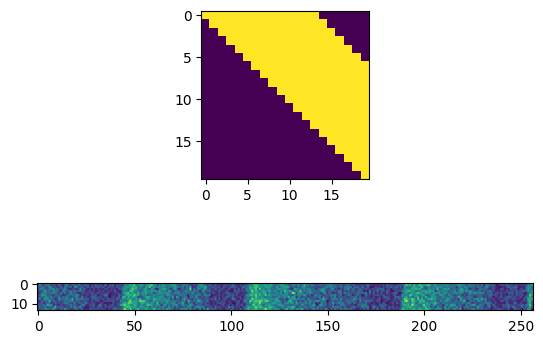

[0.627451   0.00784314 0.5882353  0.1764706  0.28627452 0.16862746
 0.00784314 0.5137255  0.4117647  0.5882353  0.16862746 0.5254902
 0.4745098  0.7058824 ]
[ 0.44135385+0.28628262j  1.1187694 -2.52808648j -3.31090006+3.13444484j
  0.11723727+0.96014151j  2.61621975+1.27061452j  1.65749282+0.62803593j
  2.11413838-0.69762745j  2.4458125 -0.94456185j  1.53281729+2.07450434j
 -0.30149981+2.66351142j]
(785.8303455599577-866.086134132706j)


In [5]:
# 生成模糊矩阵
D_array = np.zeros((M_users*L_symbols+M_users-1,M_users*L_symbols))
for i in range(M_users*L_symbols):
    row_tail = min(i+M_users,M_users*L_symbols+M_users-1)
    D_array[i:row_tail,i] = 1.
plt.subplot(211)
plt.imshow(D_array[-20:,-20:])
d_data_vec = d_data_h.T.reshape(-1,1)

# # Mat Mul Method
# D_array = np.zeros([M_users*(L_symbols+1)-1, M_users*L_symbols])*(1+0j)
# for idx in range(M_users*L_symbols):    # 按列依次赋值
#     D_array[np.arange(M_users)+idx, idx] = hh[np.mod(idx,M_users)]
# d_data_vec = d_data.T.reshape(-1,1)
# plt.imshow(d_data_vec)
y_out = D_array @ d_data_vec
# np.save('my_sample.npy',y_out.flatten())
y_out = awgn(y_out,SNR_db_global) # add white gaussian noise
y_out1 = np.vstack((y_out,[0.]))    # 为了能形成信号矩阵
y_out_mat = y_out1.reshape(L_symbols+1,M_users).T
plt.subplot(212)
plt.imshow(np.abs(y_out_mat))
plt.show()
print(d_data[:,0])
print(y_out_mat[0:10,0].flatten())
# print(np.sum((y_out_mat-convSame)**2))
print(np.sum((y_out1.flatten()-(convSame.T.reshape(-1)))**2))

2.3 可以自定义卷积核

In [6]:
# blur_kernel = np.zeros((2*M_users-1,5))
# kernel_height = 2*M_users-1
# blur_kernel[int(kernel_height/5):int(kernel_height/4),3] = 1.
# blur_kernel[int(kernel_height/4*3):int(kernel_height/5*4),1] = 1.
# blur_kernel[int(kernel_height/4):int(kernel_height/4*3),2] = 1.
# blur_kernel[0:int(kernel_height/5),4] = 1.
# blur_kernel[int(kernel_height/5*4):,0] = 1.
# plt.imshow(blur_kernel)
# plt.show()

3.0 解决混叠问题：Phase Align Assumption

In [7]:
MthFiltersIndex = (np.arange(L_symbols) + 1) * M_users - 1
output = y_out[MthFiltersIndex]
print(np.mean(np.abs(output-np.sum(d_data,axis=0))**2))

67.58375163828298


3.1 解决混叠问题：ML estimation

(3597, 3584) (3597, 1)


d:\ana\envs\mypytorch\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
d:\ana\envs\mypytorch\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:216: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


(3584, 1) (3584, 1)


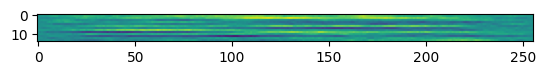

4561.408320298609


In [8]:
import scipy.sparse.linalg as srlg
from scipy.sparse import csr_matrix
D_array = np.zeros([M_users*(L_symbols+1)-1, M_users*L_symbols])*(1+0j)
for idx in range(M_users*L_symbols):    # 按列依次赋值
    D_array[np.arange(M_users)+idx, idx] = hh[np.mod(idx,M_users)]
print(D_array.shape,y_out.shape)
# restored = np.linalg.lstsq(D_array,y_out)[0]    # 直接求解：5000x5000~29s
D_array_csr = csr_matrix(D_array)               # 稀疏矩阵求解：5000x5000~2.7s
pn = get_pn(y_out.flatten(),SNR_db_global)
noise_sigma = csr_matrix(np.diag([pn]*(M_users*(L_symbols+1)-1)))
noise_sigma_inv = srlg.inv(noise_sigma)
# d_inv_csr = srlg.inv(D_array_csr.conj().T@D_array_csr)
# restored = d_inv_csr @ D_array_csr.conj().T @ y_out  
d_inv_csr = srlg.inv(D_array_csr.conj().T@noise_sigma_inv@D_array_csr)
restored = d_inv_csr @ D_array_csr.conj().T @noise_sigma_inv@ y_out  
print(restored.shape,d_data_vec.shape)
x_re_mat0 = restored.flatten()[:L_symbols*M_users].reshape(L_symbols,M_users).T
x_re_mat0 = np.real(x_re_mat0)
plt.imshow(x_re_mat0)
plt.show()
print(np.mean(np.abs(np.sum(x_re_mat0,axis=0)-np.sum(d_data,axis=0))**2))
# MxL>5000时，运行缓慢

3.2 解决混叠问题：Winner Filter estimation

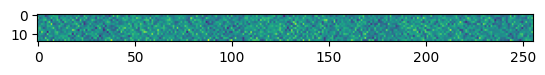

11.2936873369703


In [9]:
def wiener_deconv(input, kernel, SNR_db=0):       
    ''' 
    Winner filter with given blur kernel
    ---
    input: M长序列，可能包含周边padding
    kernel: 补全至M的卷积核
    '''
    K = 1 / (np.power(10, SNR_db / 10))
    input_fft = fft.fft(input)
    kernel_fft = fft.fft(kernel)
    kernel_fft_1 = np.conj(kernel_fft) / (np.abs(kernel_fft) ** 2 + K)
    result = fft.ifft(input_fft * kernel_fft_1)
    # result = np.abs(fft.fftshift(result))
    return result

def conv_test(input, kernel):
    input_fft = fft.fft(input)
    kernel_fft = fft.fft(kernel)    
    result = fft.ifft(input_fft * kernel_fft)
    # result = np.abs(result)
    return result

def deconv_test(input,kernel):
    input_fft = fft.fft(input)
    kernel_fft = fft.fft(kernel)
    result = fft.ifft(input_fft / kernel_fft)
    # result = np.abs(result)
    return result

def pre_inverse_kernel(kernel):
    kernel = kernel.flatten()
    kernel_new = np.flip(kernel)
    kernel_new = np.roll(kernel_new,1)
    return kernel_new

# test_x = np.array([1,2,3,4,5,6])
# test_y = np.array([2,1])
# pad_len = len(test_x)+len(test_y)-1
# test_x = np.hstack((test_x,np.array([0]*(pad_len-len(test_x)))))
# test_y = np.hstack((test_y,np.array([0]*(pad_len-len(test_y)))))
# test_y = pre_inverse_kernel(test_y)
# y_out = conv_test(test_x,test_y)
# print(y_out)
# x_re = wiener_deconv(y_out,test_y,100)
# # x_re = deconv_test(y_out,test_y)
# print(x_re)

y_out = y_out.flatten()
pad_len = len(y_out)
blur_kernel_1d = np.hstack((blur_kernel_1d,np.array([0]*(pad_len-len(blur_kernel_1d)))))
x_re_pad = wiener_deconv(y_out,blur_kernel_1d,SNR_db_global)   # 低SNR下，用更低的SNR估计取得效果更好
x_re_mat = x_re_pad[:L_symbols*M_users].reshape(L_symbols,M_users).T
x_re_mat = x_re_mat/hh_expand
x_re_mat = np.real(x_re_mat)
# print(hh_expand[:5,:5])
plt.imshow(x_re_mat.real)
plt.show()
print(np.mean(np.abs(np.sum(x_re_mat,axis=0)-np.sum(d_data,axis=0))**2))

3.3 LMMSE解决

(3584, 3597)
(3584, 1)


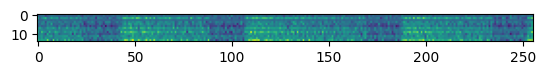

(14, 256) (14, 256)
2.8047083534538158


In [10]:
# 计算每一行的均值
mean_vector = np.mean(d_data, axis=1)
mu_vec = csr_matrix(np.tile(mean_vector.flatten(),L_symbols))

# 计算每一行的方差
variance_vector = np.var(d_data, axis=1)
d_vector = np.tile(variance_vector.flatten(),L_symbols)
d_hat_mat = csr_matrix(np.diag(d_vector))


pn = get_pn(y_out.flatten(),SNR_db_global)
noise_sigma = csr_matrix(np.diag([1.]*(M_users*(L_symbols+1)-1)))
tmp_inv_mat = srlg.inv(D_array_csr @ d_hat_mat @ D_array_csr.T.conj() + noise_sigma)
a_mat = d_hat_mat @ D_array_csr.T.conj() @ tmp_inv_mat
I_mat = np.diag([1.]*(M_users*L_symbols))
print(a_mat.shape)
restored = a_mat @ y_out.reshape(-1,1) + (I_mat - a_mat @ D_array_csr) @ mu_vec.reshape(-1,1)
print(restored.shape)
x_re_mat1 = restored.flatten()[:L_symbols*M_users].reshape(L_symbols,M_users).T
x_re_mat1 = np.real(x_re_mat1)
plt.imshow(x_re_mat1)
plt.show()
print(x_re_mat1.shape,d_data.shape)
sum_est = np.array(np.sum(x_re_mat1,axis=0))    # matrix to array
sum_gt = np.sum(d_data,axis=0)

print(np.mean(np.abs(sum_est-sum_gt)**2))

3.4 解决混叠问题：Deep Learning Based

d:\ana\envs\mypytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


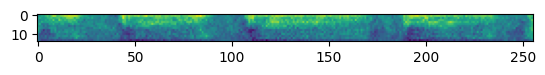

2097.0916


In [11]:
# tiny U-Net
from single_inference import inference
# hh = np.array([1.]*20).reshape(-1,1)
output,image = inference(y_out.flatten(),'../model_Umod2.pth',M_users,L_symbols,hh,SNR_db_global)
image = image.real
plt.imshow(image)
plt.show()
print(np.mean(np.abs(np.sum(image,axis=0)-np.sum(d_data,axis=0))**2))